# **1. Mounting Google Drive**

function KeepClicking(){
console.log("Clicking");
document.querySelector("colab-connect-button").click()
}
setInterval(KeepClicking,60000)

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# **2. Libraries**

In [2]:
import os
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import time
import math

import cv2
print(f"OpenCV Version: {cv2.__version__}")

print(f'TensorFlow Version : {tf.__version__}')
import matplotlib.pyplot as plt

OpenCV Version: 4.1.2
TensorFlow Version : 2.7.0


# **3. Data load**

In [3]:
tfrec_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/data/"
csv_folder = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/data_files/"

Reading CSV:

In [4]:
csv_columns = ["path_name","No Finding","Atelectasis","Consolidation","Infiltration","Pneumothorax","Edema","Emphysema","Fibrosis","Effusion","Pneumonia","Pleural_Thickening","Cardiomegaly","Nodule","Mass","Hernia"]
data_csv = pd.read_csv(csv_folder+"preprocessed_data.csv",skiprows=[0], header = None, names = csv_columns)
data_csv.head()

,path_name,No Finding,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,../input/data/images_001/images/00000001_000.png,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
1,../input/data/images_001/images/00000001_001.png,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False
2,../input/data/images_001/images/00000001_002.png,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False
3,../input/data/images_001/images/00000002_000.png,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,../input/data/images_001/images/00000003_000.png,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [5]:
len(data_csv)

112120

El siguiente feature_map ayuda a descomponer cada una de los samples del TREC (imagenes) en informacion importante de cada uno de ellos:

In [6]:
feature_map = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'image_id': tf.io.FixedLenFeature([], tf.string),
    'No Finding': tf.io.FixedLenFeature([], tf.int64),
    'Atelectasis': tf.io.FixedLenFeature([], tf.int64),
    'Consolidation': tf.io.FixedLenFeature([], tf.int64),
    'Infiltration': tf.io.FixedLenFeature([], tf.int64),
    'Pneumothorax': tf.io.FixedLenFeature([], tf.int64),
    'Edema': tf.io.FixedLenFeature([], tf.int64),
    'Emphysema': tf.io.FixedLenFeature([], tf.int64),
    'Fibrosis': tf.io.FixedLenFeature([], tf.int64),
    'Effusion': tf.io.FixedLenFeature([], tf.int64),
    'Pneumonia': tf.io.FixedLenFeature([], tf.int64),
    'Pleural_Thickening': tf.io.FixedLenFeature([], tf.int64),
    'Cardiomegaly': tf.io.FixedLenFeature([], tf.int64),
    'Nodule': tf.io.FixedLenFeature([], tf.int64),
    'Mass': tf.io.FixedLenFeature([], tf.int64),
    'Hernia': tf.io.FixedLenFeature([], tf.int64)
}

# **4. TF Datasets' creation**

La siguiente función permite preprocesar una determinada imagen y devolverla junto con su label (enfermedad toracica).

In [7]:
def image_decoder(data, resize_shape = (224,224)):
    example = tf.io.parse_single_example(data, feature_map)
    image = example['image']
    image = tf.io.decode_image(image, channels=3)
    image = tf.image.resize_with_pad(image, resize_shape[0], resize_shape[1])
    image.set_shape(resize_shape+(3,))
    image = tf.cast(image, tf.float32) / 255.0
    
    print([label for label in sorted(list(example.keys())) if label!='image' and label!='image_id' and label != "No Finding"])
    labels = [tf.cast(example[x], tf.float32) for x in sorted(list(example.keys())) if x!='image_id' and x != "No Finding" and x!="" and x!='image']
    
    #id = tf.cast(example['image_id'], tf.string)
    #return image, labels, id

    return image, labels

La siguiente funcion es capaz de crear un `TensorFlow Dataset` desde un archivo TF Record.
La salida va a ser un ``prefetchDataset`` lo cual permite realizar el preprocesamiento de los datos a la vez que entrenamiento de TF para no bloquear el disco disponible con demasiado I/O.
Vemos como el numero de datos spobre los que se realiza el preset esta puesto como AUTOTUNE. Esto lo que hará es cambiar el numero de datos que se sacan del buffer dinamicamente en base al entrenamiento dependiendo de cuantos datos por batch necesite este.
Info importante sobre esto: https://www.tensorflow.org/guide/data_performance#prefetching

In [8]:
def tfr_decoder(path, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size = 128, prefetch = False):

    data_list = [os.path.join(path,x) for x in os.listdir(path)]
    data_list.sort()
    #data_list = data_list[:30]
    train_end = int(len(data_list)*train_percent) 
    val_end = train_end + int(len(data_list)*val_percent)
    train_data, val_data, test_data = data_list[:train_end], data_list[train_end:val_end], data_list[val_end:]
    
    trainds = tf.data.TFRecordDataset(train_data)
    trainds = trainds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    trainds = trainds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
    #print("Lenght of train dataset: " + str(sum(1 for _ in trainds)))
    
    valds = tf.data.TFRecordDataset(val_data)
    valds = valds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    valds = valds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
    #print("Lenght of val dataset: " + str(sum(1 for _ in valds)))

    testds = tf.data.TFRecordDataset(test_data)
    testds = testds.map(image_decoder, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    testds = testds.filter(lambda img, labels: tf.math.reduce_sum(labels) != 0)
    #print("Lenght of val dataset: " + str(sum(1 for _ in testds)))

    if shuffle:
        trainds = trainds.shuffle(1024)

    if batch_size != None:
      trainds = trainds.batch(batch_size)
      valds = valds.batch(batch_size)
      testds = testds.batch(batch_size)

    if prefetch:
      trainds = trainds.prefetch(tf.data.experimental.AUTOTUNE)
      valds = valds.prefetch(tf.data.experimental.AUTOTUNE)
      testds = testds.prefetch(tf.data.experimental.AUTOTUNE)
      
    return trainds, valds, testds

Creamos los datasets de **Train y Validation**


In [9]:
train_ds, val_ds, test_ds = tfr_decoder(tfrec_folder, shuffle=True, train_percent=0.8, val_percent=0.1, batch_size = 512, prefetch = True)
print(type(train_ds))
print(train_ds)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 14)), types: (tf.float32, tf.float32)>


In [10]:
train_size = 41278
val_size = 5052
test_size = 5429

# **5. Showing datasets images**

In [11]:
class_names_list = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

### With next(iter(df))

In [12]:
def show_batch(X, Y):
    plt.figure(figsize=(15, 15))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(X[n])
        
        result = [x for i, x in enumerate(class_names_list) if Y[n][i]]
        title = "+".join(result)

        plt.title(title)
        plt.axis("off")

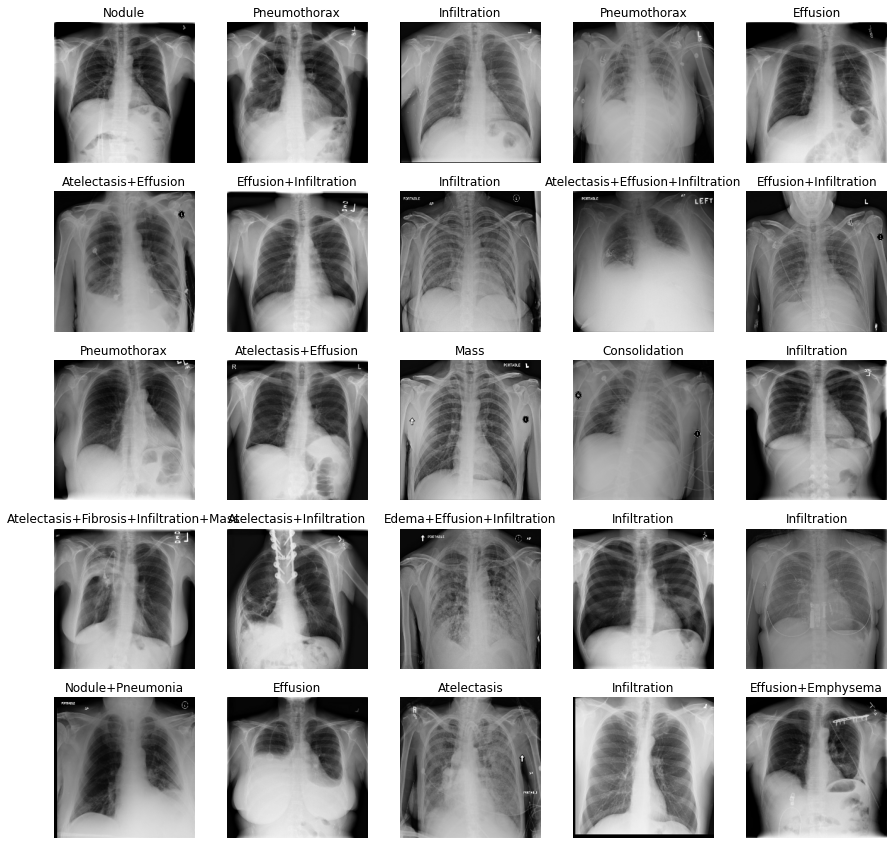

In [13]:
image_viz, label_viz = next(iter(train_ds))


show_batch(image_viz.numpy(), label_viz.numpy())

# **6. Modeling**

### 6.1 DenseNet Model

#### 6.1.1 Model construction
La ultima capa queremos que tenga 15 neuronas ( `out_shape = len(class_names_list)` ) y una activacion activacion `sigmoid` para que la salida de la red sean probabilidades para cada una de las patologías.

In [19]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(),
    layers.experimental.preprocessing.RandomRotation(0.25),
    layers.experimental.preprocessing.RandomZoom(0.25)
  ]
)

In [20]:
image_size =  (224, 224)
out_shape = len(class_names_list)

In [21]:
densenet= tf.keras.applications.DenseNet121(input_shape = image_size +(3,), include_top = False, weights = 'imagenet')
print(len(densenet.layers))

427


In [22]:
for layer in densenet.layers:
  if 'conv5' in layer.name:
    layer.trainable = True
  else:
    layer.trainable = False

In [23]:
inputs = tf.keras.Input(shape=image_size + (3, ), name='input')
x = data_augmentation (inputs)
#----- Preprocessing
x = densenet(inputs)
x = layers.Flatten() (x)
x = layers.BatchNormalization() (x)
x = layers.Dense(256, "relu") (x)
x = layers.Dropout(0.4) (x)
x = layers.BatchNormalization() (x)
x = layers.Dense(128, "relu") (x)
x = layers.Dropout(0.4) (x)
x = layers.BatchNormalization() (x)
x = layers.Dense(64, "relu") (x)
x = layers.Dropout(0.4) (x)
x = layers.BatchNormalization() (x)
outputs = layers.Dense(out_shape, 'sigmoid')(x)

In [24]:
densenet_model = keras.Model(inputs = inputs, outputs = outputs, name = "densenet_model")
densenet_model.summary()


Model: "densenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 batch_normalization_4 (Batc  (None, 50176)            200704    
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               12845312  
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                    

#### 6.1.2 Fitting

In [25]:
densenet_model.compile(loss='binary_crossentropy',
             optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
             metrics=[tf.keras.metrics.AUC(multi_label=True)])

In [26]:
path_to_models = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/"
model_name = "desNet_20epoch_lr0p01_RMS_512bs.h5"

path_to_history = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/historiales/"
history_name = "history_desNet_20epoch_lr0p01_RMS_512bs.pickle"

models_checkpoints_path = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/checkpoints/"


In [27]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint( filepath = models_checkpoints_path + "desNet_20epoch_lr0p01_RMS_512bs_{epoch:02d}.h5",
                                   monitor = "val_loss",
                                   mode = "min",
                                   save_best_only = True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)

In [28]:
start = time.time()
history = densenet_model.fit(train_ds, 
                             epochs=20,
                             validation_data=val_ds,
                             callbacks = [checkpoint_cb, es])
end = time.time()
train_time = (end-start)/60
print(str(train_time) + " minutos tardó en entrenarr")

Epoch 1/20
81/81 [==============================] - 196s 2s/step - loss: 0.6762 - auc: 0.5324 - val_loss: 3.4713 - val_auc: 0.5216
Epoch 2/20
81/81 [==============================] - 158s 2s/step - loss: 0.4458 - auc: 0.5438 - val_loss: 32.8713 - val_auc: 0.5356
Epoch 3/20
81/81 [==============================] - 159s 2s/step - loss: 0.3240 - auc: 0.5702 - val_loss: 1.2621 - val_auc: 0.5925
Epoch 4/20
81/81 [==============================] - 160s 2s/step - loss: 0.2987 - auc: 0.6210 - val_loss: 0.2896 - val_auc: 0.6634
Epoch 5/20
81/81 [==============================] - 159s 2s/step - loss: 0.2892 - auc: 0.6644 - val_loss: 0.2812 - val_auc: 0.6932
Epoch 6/20
81/81 [==============================] - 159s 2s/step - loss: 0.2794 - auc: 0.6925 - val_loss: 0.2786 - val_auc: 0.6964
Epoch 7/20
81/81 [==============================] - 158s 2s/step - loss: 0.2664 - auc: 0.7264 - val_loss: 0.2794 - val_auc: 0.6968
Epoch 8/20
81/81 [==============================] - 160s 2s/step - loss: 0.2532 - 

Guardamos el modelo e historial:

In [29]:
path_to_models = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/modelos/"
model_name = "desNet_20epoch_lr0p01_RMS_512bs.h5"

path_to_history = "/content/drive/MyDrive/TFM/0-NIH_Chest_XRays_TFRecords/colab_notebooks/historiales/"
history_name = "desNet_20epoch_lr0p01_RMS_512bs.pickle"

In [30]:
densenet_model.save(path_to_models+model_name)

In [ ]:
densenet_model = keras.models.load_model(path_to_models+model_name)

In [31]:
import pickle
with open(path_to_history+history_name, 'wb') as f:
    pickle.dump(history, f)

INFO:tensorflow:Assets written to: ram://20db8b9a-7916-45b2-ba4b-d5cddc8aa016/assets


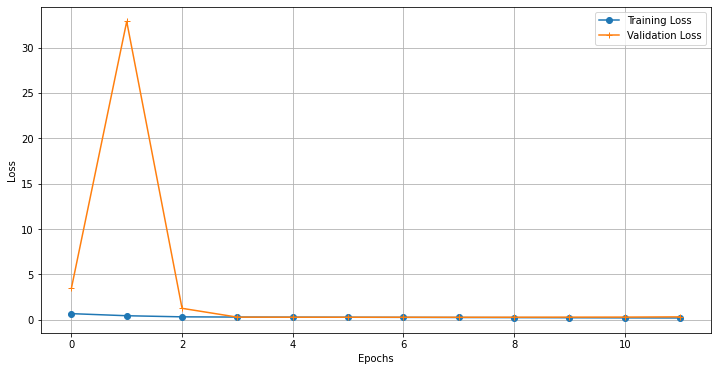

In [32]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( history.history["loss"], label = "Training Loss", marker='o')
plt.plot( history.history["val_loss"], label = "Validation Loss", marker='+')
plt.grid(True)
plt.legend()
plt.show()

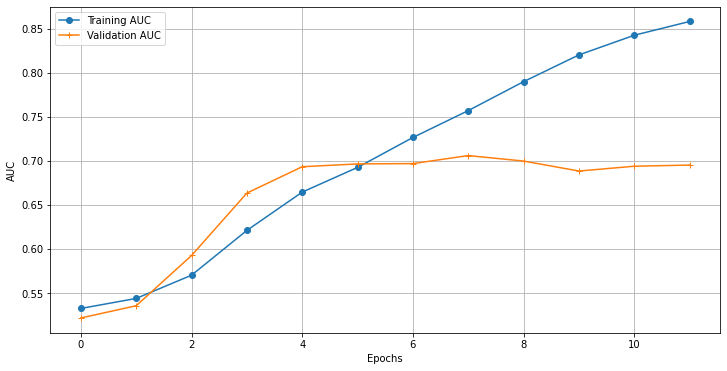

In [34]:
plt.figure(figsize = (12, 6))
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.plot( history.history["auc"], label = "Training AUC" , marker='o')
plt.plot( history.history["val_auc"], label = "Validation AUC", marker='+')
plt.grid(True)
plt.legend()
plt.show()

Una vez entrenado podemos evaluar como se comporta con datos del dataset de validación:

#### 6.1.2 Evaluation

In [35]:
test_results= densenet_model.evaluate(test_ds, return_dict = True)

print(test_results)

11/11 [==============================] - 24s 2s/step - loss: 0.2752 - auc: 0.7151
{'loss': 0.27518296241760254, 'auc': 0.7151188254356384}


In [36]:
predictions = densenet_model.predict(test_ds)

In [37]:
len(predictions)

5429

In [38]:
 y_pred_df = pd.DataFrame(predictions, columns = class_names_list)
 y_pred_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.097149,0.037032,0.075554,0.025773,0.145124,0.054209,0.071919,0.006441,0.333752,0.186139,0.214654,0.138169,0.028053,0.106617
1,0.650964,0.064083,0.049755,0.005096,0.213475,0.010408,0.010942,0.000825,0.251163,0.042234,0.039602,0.014312,0.010387,0.016918
2,0.276224,0.057592,0.047529,0.011552,0.100451,0.020353,0.047652,0.004704,0.296509,0.133789,0.164859,0.063489,0.019881,0.028765
3,0.168431,0.033821,0.034995,0.007654,0.039563,0.019006,0.044872,0.002322,0.363792,0.107690,0.170346,0.039542,0.016165,0.027730
4,0.233690,0.100106,0.142541,0.062165,0.348923,0.024076,0.024554,0.004523,0.404844,0.086913,0.079391,0.069555,0.035909,0.045524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5424,0.115021,0.020748,0.072123,0.025767,0.084622,0.103487,0.035271,0.002588,0.352261,0.087223,0.108403,0.061648,0.017772,0.250425
5425,0.197502,0.032107,0.026310,0.005963,0.031827,0.009353,0.026287,0.001443,0.457062,0.068719,0.134374,0.024674,0.014275,0.012952
5426,0.120200,0.009176,0.048299,0.009930,0.113861,0.186594,0.030093,0.002026,0.216587,0.098261,0.086181,0.079008,0.009875,0.474704
5427,0.096553,0.010001,0.026507,0.003062,0.022325,0.013758,0.057423,0.001894,0.256933,0.215496,0.319307,0.045395,0.012223,0.023449


In [39]:
def generate_df_from_prefetch_ds(tf_dataset, len_dataset):
  batch_size = tf_dataset._input_dataset._batch_size.numpy()
  batch_numbers = math.ceil(len_dataset/batch_size)
  matrix = []
  for iteration, sample in enumerate(tf_dataset.take(batch_numbers)):
    if iteration==(int(len_dataset/batch_size)):
      batch_size = len_dataset%batch_size
    for i in range(batch_size):
      matrix.append(list(sample[1][i].numpy()))
  df_test_real = pd.DataFrame(matrix, columns = class_names_list)#.apply(lambda x : x.astype("int32"))
  return df_test_real

In [40]:
y_real_df = generate_df_from_prefetch_ds(test_ds, len(predictions))

In [41]:
y_real_df

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5424,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5426,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5427,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


We are now going to define two metrics on the test dataset
- **MAP@5** (Mean Average Precision at 3): Esto simboliza que de las primeras 5 probabilidades mas altas cdevueltas por nuestro dataframe (o numero de labels target 1 si es menor), cuantas son las targets deseadas.
![MAP](https://drive.google.com/uc?id=1f36UqUgoEQso6a4GZ2ooMse4A7Hs5gnq)
- **LRAP** (Label Ranking average precision) measures the average precision of the predictive model but instead using precision-recall. It measures the label rankings of each sample. Its value is always greater than 0. The best value of this metric is 1. This metric is related to average precision but used label ranking instead of precision and recall
LRAP basically asks the question that for each of the given samples what percents of the higher-ranked labels were true labels.
Given a binary indicator matrix of ground-truth labels.
EXPLICACION:
https://stackoverflow.com/questions/55881642/how-to-interpret-label-ranking-average-precision-score/56857102
https://www.geeksforgeeks.org/multilabel-ranking-metrics-label-ranking-average-precision-ml/
![MAP](https://drive.google.com/uc?id=1SewLi0d_EupTF_awijPjtZE1Kk2f91qf)

In [42]:
from sklearn.metrics import label_ranking_average_precision_score

In [43]:
def get_LRAP(y_pred_df, y_df):
  return label_ranking_average_precision_score(y_true = y_df.values.tolist(), y_score = y_pred_df.values.tolist())

In [44]:
get_LRAP(y_pred_df, y_real_df)

0.6032647680160284

In [45]:
def get_MAP_at_k(y_pred_df, y_df, k=3, mean_over_samples = True):
  #Sort vectors based on probabilities of the prediction.
  y_p = []
  y_r = []
  for i in range(len(y_pred_df)):
    y_pred = y_pred_df.iloc[i].values.tolist()
    y_real = y_df.iloc[i].values.tolist()
    indexes_order = np.argsort(y_pred)[::-1]
    y_pred_sorted = [y_pred[k] for k in indexes_order]
    y_real_sorted = [y_real[k] for k in indexes_order]
    y_p.append(y_pred_sorted)
    y_r.append(y_real_sorted)
  #Slice vector to top_k probabilities.
  y_p_k = np.array(y_p)[:,:k]
  y_r_k = np.array(y_r)[:,:k]
  denominator = np.array(list(map(lambda x: min (x,k), np.sum(y_r,axis=1))))
  result = np.sum(y_r_k,axis=1) / denominator
  if mean_over_samples:
    result = np.mean(result)
  return result


In [48]:
get_MAP_at_k(y_pred_df, y_real_df, k = 5)

0.798824215632099

## 7. Simulating product output


Vamos a redefinir la funcion de creacion de datasets pero mas parametrizada que nos ayudara a tomar samples aleatorias del dataset

In [58]:
def get_images_from_tfr(path,length_dataset, seed=1234, n_of_samples=9):
  _,_,test_ds = tfr_decoder(path, shuffle=True, train_percent=0.8,val_percent=0.1, batch_size = None, prefetch = False)
  #Shuffle the dataset
  images = []
  y_true = []
  test_ds = test_ds.shuffle(length_dataset+1, seed = seed)
  for sample in test_ds.take(n_of_samples):
    images.append(sample[0])
    y_true.append(sample[1])
  images_arr = np.array(images)
  y_true_arr = np.array(y_true)
  print(images_arr.shape, y_true_arr.shape)
  return images_arr, y_true_arr

In [59]:
def simulate_project_output(model, images, class_names, k_prob = 3 , y_real = None, figure_size = (25,30)):

  y_pred = model.predict(images)
  n_samples = images.shape[0]

  #Getting metrics
  y_pred_df = pd.DataFrame(y_pred, columns = class_names)
  y_real_df = pd.DataFrame(y_real, columns = class_names)
  lrap = get_LRAP(y_pred_df, y_real_df)
  ap_k = get_MAP_at_k(y_pred_df, y_real_df, k=k_prob, mean_over_samples = False)
  mean_ap_k = np.mean(ap_k)

  plt.figure(figsize = figure_size)

  for n in range(n_samples):
    ax = plt.subplot(3, 3, n + 1)
    ax = plt.imshow(images[n])

    y_ref_string = [x for i, x in enumerate(class_names) if y_real[n][i]]
    title = " + ".join(y_ref_string)
    title = "ACTUAL PATOLOGY(S):  " + title + "\n"
    title = title + "PREDICTIONS:\n"

    indexes_order = np.argsort(y_pred[n])[::-1]

    predictions_string = [str(ix+1) + ". " + class_names[index] + ":  " + str(y_pred[n][index]) for ix, index in enumerate(indexes_order) if ix < k_prob]
    title = title + "\n".join(predictions_string)
    title = title + "\n---\n" + f"Precision media en {k_prob}: " + str(ap_k[n])

    lrap_n = label_ranking_average_precision_score([y_real[n]], [y_pred[n]])
    title = title + "\nLabel Ranking Average Precision: " + str(lrap_n)
    plt.title(title)
    plt.axis("off")


In [60]:
images_sample, y_sample = get_images_from_tfr(tfrec_folder, len(predictions), seed = 123)

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
(9, 224, 224, 3) (9, 14)


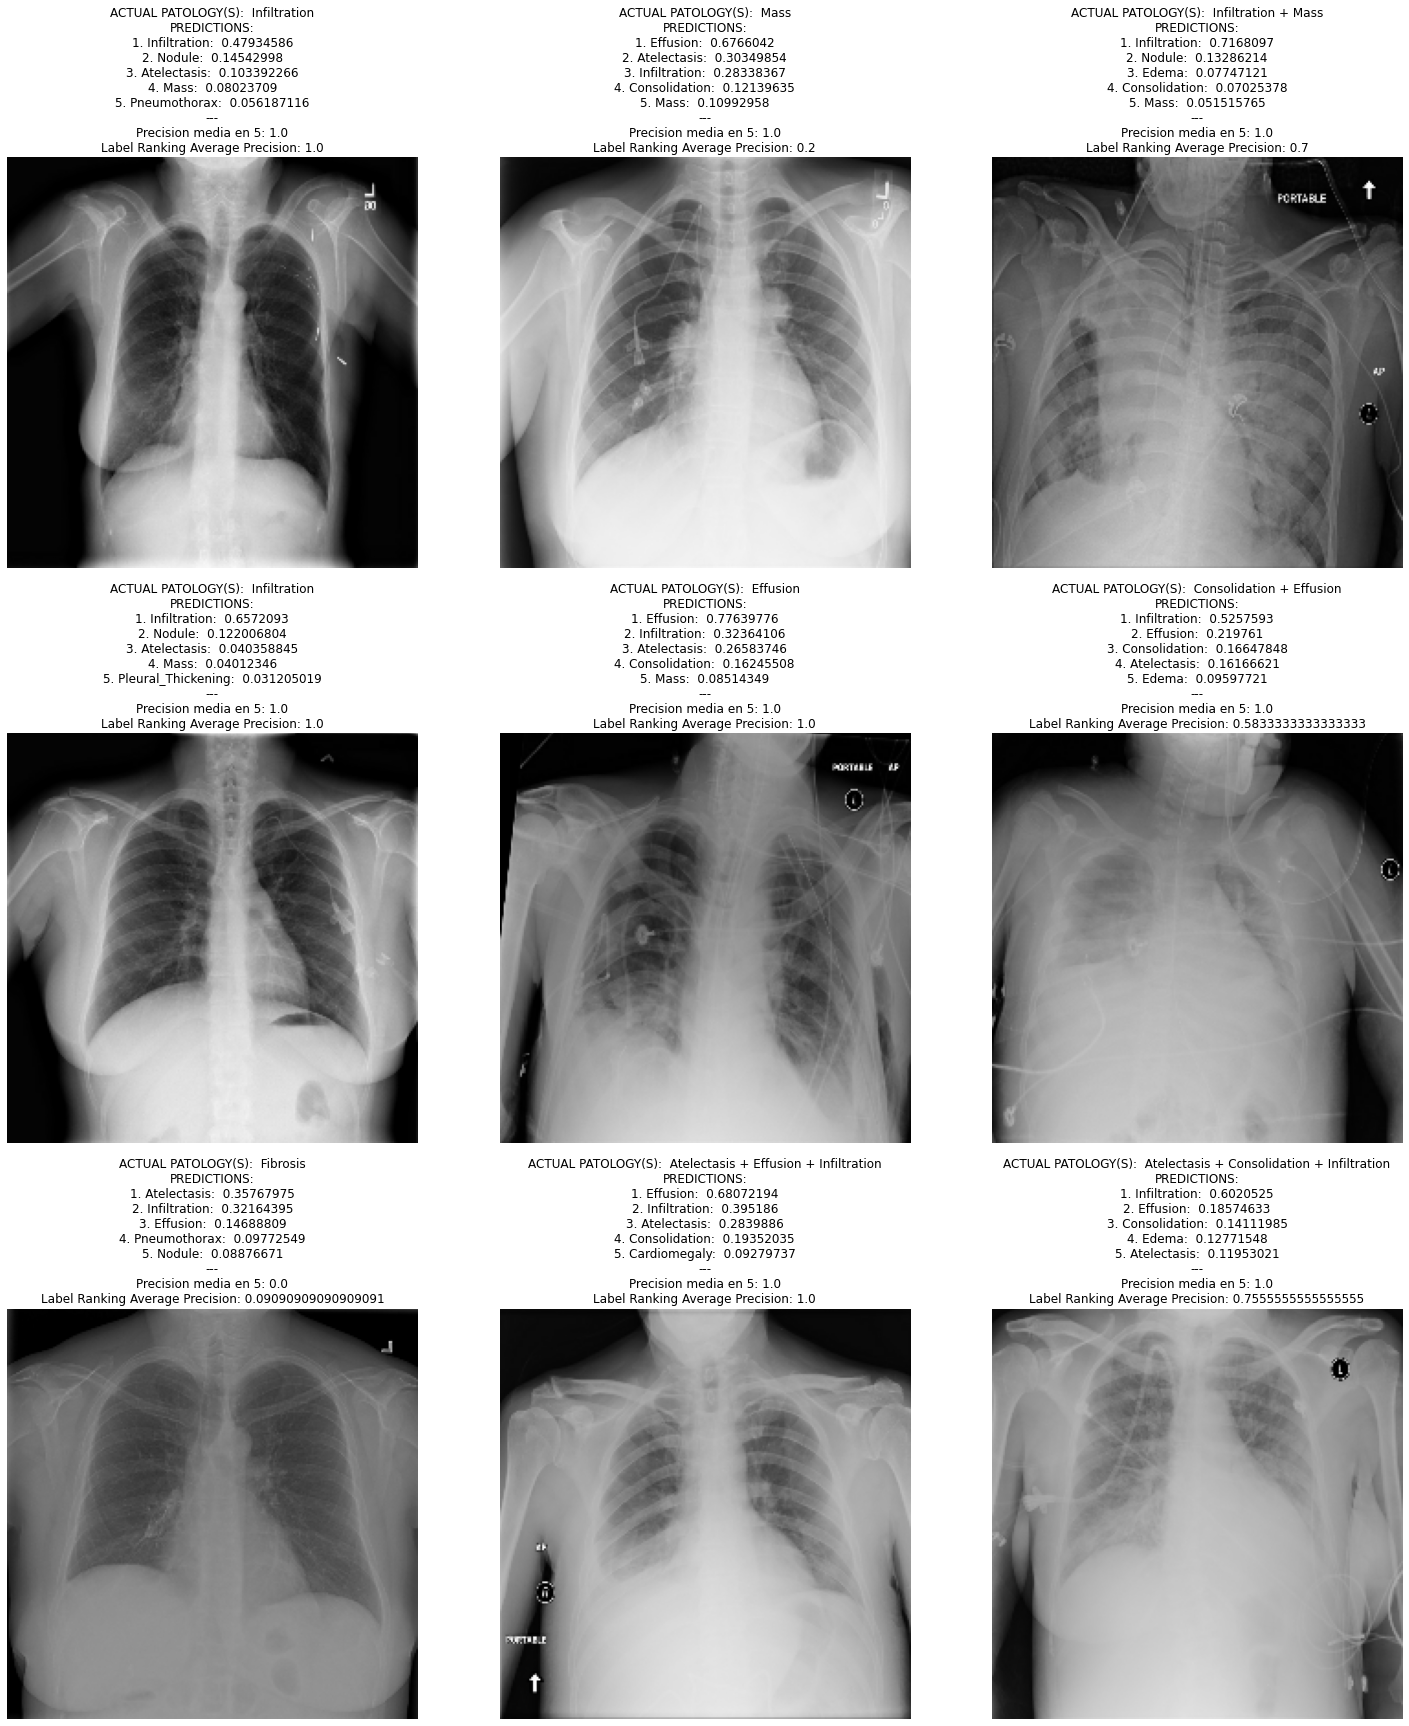

In [62]:
simulate_project_output(densenet_model, images_sample, class_names_list, k_prob = 5 , y_real = y_sample, figure_size = (25,30))